In [ ]:
# Additional requirements just for this notebook:

# !pip install huggingface_hub[cli]
# !pip install esm 
# !pip install py3Dmol

In [1]:
# General:
import os 
import io
from omegaconf import OmegaConf
# import huggingface_hub
import requests
import pathlib
import pickle
import pandas as pd
import numpy as np
import torch

# ESM:
# from esm.models.esmc import ESMC
# from esm.models.esm3 import ESM3
from esm.sdk.api import ESMProtein, LogitsConfig, GenerationConfig
from esm.utils.structure.protein_chain import ProteinChain
# from esm.utils.types import FunctionAnnotation
from biotite.database import rcsb
# from fa_helper import visualize_function_annotations, get_keywords_from_interpro, interpro2keywords
from scripts.helpers.pdb import gene_to_pdb, fetch_pdb_ids

# Visualization:
import matplotlib.pyplot as plt
from scripts.helpers.visualization import visualize_3D_protein
from PIL import Image
from IPython.display import SVG
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from synformer.models.synformer import draw_generation_results

# Chemistry:
from rdkit import Chem
import rdkit

# Synformer:
# from synformer.chem.fpindex import FingerprintIndex
# from synformer.chem.matrix import ReactantReactionMatrix
# from synformer.chem.mol import Molecule
from synformer.models.synformer import Synformer
from scripts.sample_naive import load_model, featurize_smiles, load_protein_molecule_pairs, sample

In [2]:
# Loading ESM-related configs:
assert os.path.exists("configs/esm.yml"), "Missing config file: configs/esm.yml" 
esm_config = OmegaConf.load("configs/esm.yml")
# huggingface_hub.login(esm_config.hf_token)

### 1. Loading the data

In [180]:
# Dataset paths
# protein_molecule_pairs_path = "data/protein_molecule_pairs/papyrus_val_19399.csv"
protein_molecule_pairs_path = "data/protein_molecule_pairs/papyrus_test_19399.csv"
protein_embeddings_path = "data/protein_embeddings/embeddings_selection_float16_4973.pth"
synthetic_pathways_path = "data/synthetic_pathways/filtered_pathways_370000.pth"

In [181]:
df_protein_molecule_pairs = load_protein_molecule_pairs(protein_molecule_pairs_path)
df_protein_molecule_pairs = df_protein_molecule_pairs.reset_index()

# Some example entries
df_protein_molecule_pairs.sample(10)

,SMILES,target_id,short_target_id
8252,O=[N+]([O-])c1ccc(CS(=O)(=O)c2ccc(Cl)cc2)cc1,Q03431_WT,Q03431
11543,O=C(CSc1nnc(COc2ccc(Cl)cc2)o1)N1CCCCC1,Q03431_WT,Q03431
10991,Cc1cc(C(=O)NCCC(c2ccccc2)c2ccccc2)c(C)o1,P34913_WT,P34913
1327,Nc1cncc(Nc2ccc(Oc3ccc(Cl)cc3)cc2)n1,Q15858_WT,Q15858
2845,COc1ccc(N2C(=O)c3c(cccc3)NC23CCCC3)cc1,Q03431_WT,Q03431
6027,Cc1cc(C=Cc2ccccc2)nc(N)n1,Q14833_WT,Q14833
615,Fc1ccc2cc(-c3cscc3)ncc2c1,Q03431_WT,Q03431
1655,N#Cc1c(NC(=O)CSc2n[nH]cn2)sc2c1CCCC2,Q03431_WT,Q03431
7840,CN(CCC(=O)c1cscc1)Cc1ccccc1,Q7M0F8_WT,Q7M0F8
13666,N#CC1CCCN1C(=O)CNC(=O)c1ccnc(Br)c1,P48147_WT,P48147


In [182]:
protein_embeddings = torch.load(protein_embeddings_path, map_location=torch.device("cpu"))
print(len(protein_embeddings), "protein embeddings")

synthetic_pathways = torch.load(synthetic_pathways_path, map_location=torch.device("cpu"))
print(len(synthetic_pathways), "synthetic pathways")

4973 protein embeddings
70936 synthetic pathways


### 2. Loading the model

In [6]:
# Protein-Synformer model configs
# config_path = "configs/prot2drug.yml"  
# config = OmegaConf.load(config_path)

# Sampling settings
model_path = "data/trained_weights/epoch=23-step=28076.ckpt"
config_path = None
device = "cpu"

In [7]:
model, fpindex, rxn_matrix = load_model(model_path, config_path, device)

### 3. Example

In [10]:
# Random example
ex_smiles, ex_target_id, ex_short_target_id = df_protein_molecule_pairs.sample().iloc[0]
ex_protein_embeddings = protein_embeddings[ex_target_id].float()
ex_synthetic_pathway_true = synthetic_pathways[ex_smiles]

print("SMILES:", ex_smiles)
print("Target:", ex_target_id)
print("Protein embeddings:", ex_protein_embeddings.shape)
print("True synthetic pathway:", ex_synthetic_pathway_true)

SMILES: Cc1cc(C)c2c(N)c(C(=O)NN=Cc3cccs3)sc2n1
Target: P02791_WT
Protein embeddings: torch.Size([177, 1152])
True synthetic pathway: [(1, -1), (3, 7205), (3, 671), (2, 2), (0, -1)]


In [11]:
ex_pdb_id, ex_df_pdb_ids = fetch_pdb_ids(ex_short_target_id)
print("PDB ID:", ex_pdb_id)

ex_protein_chain = ProteinChain.from_pdb(rcsb.fetch(ex_pdb_id, "pdb"), chain_id="A") 

# Get protein object with all the ground-truth data (except function for some reason) 
# In the code, they don't provide a way to automatically fetch function annotations, 
# instead I have to fetch them myself and then set ex_protein.function_annotations 
ex_known_protein = ESMProtein.from_protein_chain(ex_protein_chain) 

# Get protein with just the sequence data 
# So that we can predict the other tracks later 
# ex_protein = ESMProtein(sequence=ex_protein_chain.sequence) 

# print(len(ex_known_protein.sequence))
print(ex_known_protein.sequence)

# TODO: have ESM predict binding site and then also visualize it 
# (already done in Binding Site notebook)






visualize_3D_protein(ex_known_protein, style="cartoon")

PDB ID: 1AEW
SQIRQNYSTEVEAAVNRLVNLYLRASYTYLSLGFYFDRDDVALEGVCHFFRELAEEKREGAERLLKMQNQRGGRALFQDLQKPSQDEWGTTPDAMKAAIVLEKSLNQALLDLHALGSAQADPHLCDFLESHFLDEEVKLIKKMGDHLTNIQRLVGSQAGLGEYLFERLTL


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [167]:
info, result = sample(
    ex_smiles, 
    ex_target_id,
    model, 
    fpindex, 
    rxn_matrix,  
    protein_embeddings, 
    device,
    repeat=50
)
# prints: analog.sim(mol), cnt_rxn, log_likelihood, analog.smiles

  0%|          | 0/23 [00:00<?, ?it/s]

{'ll': -120.03960418701172, 'cnt_rxn': 0, 'similarity': 0.01818181818181818}
{'ll': -125.82005310058594, 'cnt_rxn': 0, 'similarity': 0.017543859649122806}
{'ll': -47.19971466064453, 'cnt_rxn': 0, 'similarity': 0.0}
{'ll': -43.72816848754883, 'cnt_rxn': 0, 'similarity': 0.05172413793103448}
{'ll': -129.00570678710938, 'cnt_rxn': 0, 'similarity': 0.08620689655172414}


In [179]:
# Best one:
best_idx = pd.DataFrame(info).T["similarity"].idxmax()

print("True:", ex_smiles)
print("Pred:", info[best_idx]["smiles"])

info[best_idx]

True: Cc1cc(C)c2c(N)c(C(=O)NN=Cc3cccs3)sc2n1
Pred: CC(C)NC(=O)NC(C)C


{'smiles': 'CC(C)NC(=O)NC(C)C',
 'analog': <synformer.chem.mol.Molecule at 0x16a64bbb0>,
 'stack': <synformer.chem.stack.Stack at 0x1471ada80>,
 'll': -129.00570678710938,
 'cnt_rxn': 0,
 'similarity': 0.08620689655172414}

In [ ]:
# TODO
# draw_generation_results(result)[best_idx]  

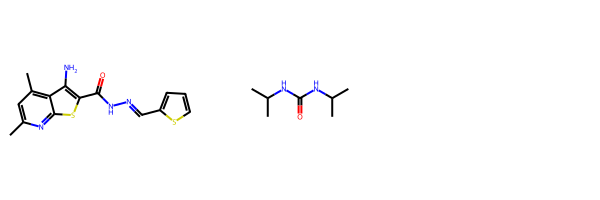

In [177]:
Draw.MolsToGridImage((
    Chem.MolFromSmiles(ex_smiles),     # true 
    Chem.MolFromSmiles(info[best_idx]["smiles"])  # predicted
))

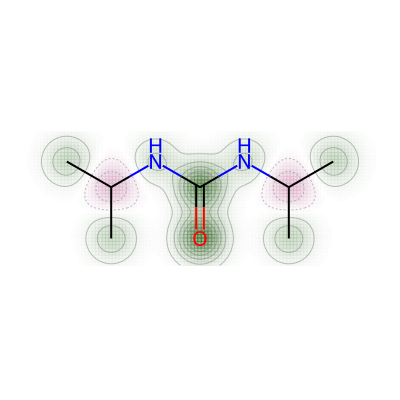

In [175]:
# Similarity map
# Source: https://greglandrum.github.io/rdkit-blog/posts/2020-01-03-similarity-maps-with-new-drawing-code.html

d = Draw.MolDraw2DCairo(400, 400)
_, max_weight = SimilarityMaps.GetSimilarityMapForFingerprint(
    Chem.MolFromSmiles(ex_smiles),
    Chem.MolFromSmiles(info[best_idx]["smiles"]), 
    lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType="bv"), 
    draw2d=d
)
d.FinishDrawing()
Image.open(io.BytesIO(d.GetDrawingText()))

### 4. Evaluation

In [213]:
# Run over entire test set and compute metrics, e.g. Tanimoto distance 
# This is not very efficient

num_eval_pairs = 2
repeat = 50 

df_eval_pairs = df_protein_molecule_pairs.sample(num_eval_pairs)

eval_data = []

for _, row in df_eval_pairs.iterrows():
    true_smiles, true_target_id = row[["SMILES", "target_id"]]
    print((smiles, target_id))
    _info, _result = sample(
        true_smiles, 
        true_target_id,
        model, 
        fpindex, 
        rxn_matrix,  
        protein_embeddings, 
        device,
        repeat=50
    )
    print(len(_info), "samples")
    if len(_info) > 0:
        best_idx = pd.DataFrame(_info).T["similarity"].idxmax()
        for idx, entry in _info.items():
            eval_data.append({
                "true_smiles": true_smiles,
                "true_target_id": true_target_id,
                "is_best": idx == best_idx,
                **entry,
            })

('Cc1ccc(NC(=O)c2ccc(CSc3ncnc4c3nc[nH]4)cc2)c(C)c1', 'Q03431_WT')


  0%|          | 0/23 [00:00<?, ?it/s]

{'ll': -53.74906539916992, 'cnt_rxn': 0, 'similarity': 0.10666666666666667}
{'ll': -71.41937255859375, 'cnt_rxn': 0, 'similarity': 0.1111111111111111}
2 samples
('Cc1ccc(NC(=O)c2ccc(CSc3ncnc4c3nc[nH]4)cc2)c(C)c1', 'Q03431_WT')


  0%|          | 0/23 [00:00<?, ?it/s]

{'ll': -34.862728118896484, 'cnt_rxn': 0, 'similarity': 0.037037037037037035}
{'ll': -97.85086059570312, 'cnt_rxn': 1, 'similarity': 0.10256410256410256}
2 samples


In [215]:
df_eval = pd.DataFrame(eval_data)
df_eval

,true_smiles,true_target_id,is_best,smiles,analog,stack,ll,cnt_rxn,similarity
0,CCc1ccc(Sc2cc(C(=O)NCCN3CCOCC3)c3ccccc3n2)cc1,Q03431_WT,False,COc1ccc(N2CCC(=O)CC2)cc1,<synformer.chem.mol.Molecule object at 0x16a68...,(<synformer.chem.mol.Molecule object at 0x16a6...,-53.749065,0,0.106667
1,CCc1ccc(Sc2cc(C(=O)NCCN3CCOCC3)c3ccccc3n2)cc1,Q03431_WT,True,C[Si](C)(C)C#Cc1ccccc1O,<synformer.chem.mol.Molecule object at 0x4bfa8...,(<synformer.chem.mol.Molecule object at 0x4bfa...,-71.419373,0,0.111111
2,CCn1c(C=NNC(=O)c2ccc(OC)cc2)nc2c1cccc2,Q03431_WT,False,Oc1cc(O)cc(O)c1,<synformer.chem.mol.Molecule object at 0x4ce44...,(<synformer.chem.mol.Molecule object at 0x4ce4...,-34.862728,0,0.037037
3,CCn1c(C=NNC(=O)c2ccc(OC)cc2)nc2c1cccc2,Q03431_WT,True,CN(C(=O)c1cnc(Cl)nc1)C1CCCNCC1,<synformer.chem.mol.Molecule object at 0x153e9...,(<synformer.chem.mol.Molecule object at 0x4cf4...,-97.850861,1,0.102564
